In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import datajoint as dj
from photonics.space import Space

In [2]:
schema = dj.schema('photonics')

Connecting dimitri@localhost:3306


In [3]:
@schema
class DSim(dj.Lookup):
    definition = """
    # Detector Field Specification
    dsim : int
    --- 
    dsim_description  : varchar(1024)  
    detector_type='one-sided' : varchar(30)   # choice in simulation
    detector_width=10.00: decimal(5,2)   # (um) along x-axis
    detector_height=10.00:  decimal(5,2)  # (um) along y-axis
    anisotropy = 0.88 : float  # factor in the Henyey-Greenstein formula
    absorption_length = 14000 : float # (um)  average travel path before a absoprtion event 
    scatter_length=100 : float # (um) average travel path before a scatter event
    volume_dimx = 1000 : int unsigned # (voxels)
    volume_dimy = 1000 : int unsigned # (voxels)
    volume_dimz = 1000 : int unsigned # (voxels)
    pitch = 2.2 : float  # (um)  spatial sampling period of the model volume
    """
   
    contents = [
        dict(dsim=0, detector_type='one-sided', detector_height=50, 
             dsim_description='100% Efficient Lambertian 10x50 rect'),
        dict(dsim=1, detector_type='one-sided', detector_height=10, 
             dsim_description='100% Efficient Lambertian 10x10 rect'),
        dict(dsim=2, detector_type='narrowed', detector_height=10, 
             dsim_description="Narrow selective as 4th power of cosine, 10x10 rect")]

In [4]:
@schema
class DField(dj.Computed):
    definition = """
    # Detector Field Reference Volume
    -> DSim
    ---
    volume : blob@photonics   # probability of a photon emitted at given point getting picked up by the given detector
    max_value : float   # should be < 1.0
    total_photons : int unsigned
    """
    
    def make(self, key):
        spec = (DSim & key).fetch1()
        
        kwargs = {k: spec[k] for k in spec if k in {
            'pitch', 'anisotropy', 'scatter_length', 'absorption_length', 'detector_type'}}
        
        kwargs.update(
            dims=tuple(spec[k] for k in ('volume_dimx', 'volume_dimy', 'volume_dimz')),
            emitter_spread='spherical',
            emitter_size=(float(spec['detector_width']), float(spec['detector_height']), 0))
        
        space = Space(**kwargs)
        space.run(hops=500_000)
        volume = space.volume * space.emitter_area
        self.insert1(dict(
            key, 
            volume=np.float32(volume), 
            max_value=volume.max(),
            total_photons=space.total_count))        

    
    def plot(self, figsize=(8, 8), axis=None, gamma=0.7, cmap='gray_r', title=''):
        from matplotlib_scalebar.scalebar import ScaleBar
        info = (self * DSim).fetch1()
        if axis is None:
            _, axis = plt.subplots(1, 1, figsize=(8, 8))
        axis.imshow((info['volume'].sum(axis=0))**gamma, cmap=cmap)
        axis.axis(False)
        scale_bar = ScaleBar(info['pitch']*1e-6)
        axis.add_artist(scale_bar)
        title = f"{title}\n{info['total_photons']/1e6:0.2f} million simulated photons"
        axis.set_title(title)
        

In [5]:
DField.populate()

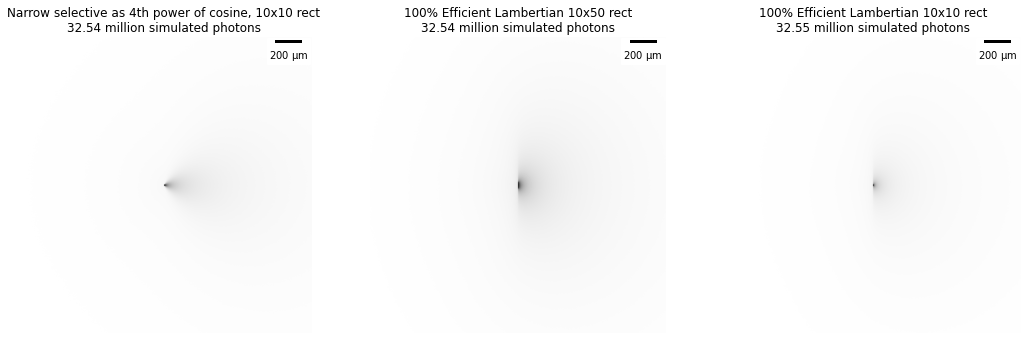

In [9]:
keys = DField.fetch('KEY')
fig, ax = plt.subplots(1, len(keys), figsize=(6*len(keys), 6))
for a, key in zip(ax.flatten(), keys):
    (DField & key).plot(axis=a, title=(DSim & key).fetch1('dsim_description'))
fig.savefig('detector-fields.pdf')

In [10]:
!open detector-fields.pdf

In [8]:
@schema
class ESim(dj.Lookup):
    definition = """
    # Detector Field Specification
    esim : int
    --- 
    esim_description : varchar(1024)  
    emitter_width=10.00: decimal(5,2)   # (um) along x-axis
    emitter_height=10.00:  decimal(5,2)  # (um) along y-axis
    anisotropy = 0.88 : float  # factor in the Henyey-Greenstein formula
    absorption_length = 14000 : float # (um)  average travel path before a absoprtion event 
    scatter_length=100 : float # (um) average travel path before a scatter event
    volume_dimx = 1000 : int unsigned # (voxels)
    volume_dimy = 1000 : int unsigned # (voxels)
    volume_dimz = 1000 : int unsigned # (voxels)
    pitch = 2.2 : float  # (um)  spatial sampling period of the model volume
    """
    
    contents = [
        dict(esim=1, esim_description="Lambertian 10 x 10"),
        
        dict(esim=10, esim_description="Narrowed to \pi/6")
        
        dict(esim=11, esim_description="Narrowed to \pi/6, steered upward pi/3")

        dict(esim=12, )
    ]

SyntaxError: invalid syntax (<ipython-input-8-140d4eacbd51>, line 24)

In [ ]:
@schema
class EmitterField(dj.Computed):
    definition = """
    # Emitter Field Reference Volume
    -> EmitterSpec
    ---
    volume : blob@photonics   # probability of a photon emitted at given point getting picked up by the given detector
    total_photons : int unsigned
    """
    
    def make(self, key):
        spec = (DetectorSpec & key).fetch1()
        
        kwargs = {k: spec[k] for k in spec if k in {
            'pitch', 'anisotropy', 'scatter_length', 'absorption_length', 'detector_type'}}
        
        kwargs.update(
            dims=tuple(spec[k] for k in ('volume_dimx', 'volume_dimy', 'volume_dimz')),
            emitter_spread='spherical',
            emitter_size=(float(spec['detector_width']), float(spec['detector_height']), 0))
        
        space = Space(**kwargs)
        space.run(hops=500_000)
        volume = space.volume * space.emitter_area
        self.insert1(dict(
            key, 
            volume=np.float32(volume), 
            max_value=volume.max(),
            total_photons=space.total_count))        

    
    def plot(self, figsize=(8, 8), axis=None, gamma=0.7, cmap='gray_r', title=''):
        from matplotlib_scalebar.scalebar import ScaleBar
        info = (self * DetectorSpec).fetch1()
        if axis is None:
            _, axis = plt.subplots(1, 1, figsize=(8, 8))
        axis.imshow((info['volume'].sum(axis=0))**gamma, cmap=cmap)
        axis.axis(False)
        scale_bar = ScaleBar(info['pitch']*1e-6)
        axis.add_artist(scale_bar)
        title = f"{title}\n{info['total_photons']/1e6:0.2f} million simulated photons"
        axis.set_title(title)
        